In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/pytorch')
import helper_functions
from helper_functions import plot_decision_boundary

### 1. prepare data

In [ ]:
X, y = make_blobs(n_samples = 1000, centers = 4, random_state = 42,
                  cluster_std = 1.5)

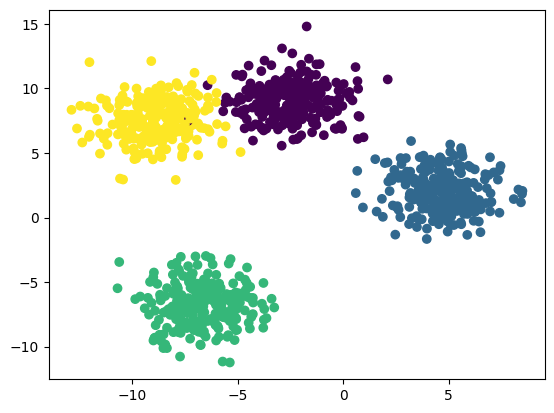

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

In [ ]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.int64)
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,
                                                    random_state = 42)

### 2. define model, loss function, optimizer, and metric (accuracy function)

this time, softmax is built in the loss criterion; thus no softmax on the last layer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class NN_BlobsModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """ Initializes a multi-class classification model for blobs

        Args:
            input_features (int): number of inputs
            output_features (int): number of outputs
            hidden_units (int, optional): number of hidden units, default to 8

        Returns:
            an initialized model
        """
        super().__init__()
        self.layer1 = nn.Linear(input_features, hidden_units * 2)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units * 2, hidden_units)
        self.output = nn.Linear(hidden_units, output_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.layer1(x)
        res = self.relu(res)
        res = self.layer2(res)
        res = self.relu(res)
        return self.output(res)

model = torch.compile(NN_BlobsModel(2, 4).to(device))
model.state_dict()

OrderedDict([('_orig_mod.layer1.weight',
              tensor([[ 0.6628, -0.3660],
                      [ 0.4776,  0.1728],
                      [ 0.5928,  0.5202],
                      [-0.6761, -0.3949],
                      [ 0.0721,  0.3373],
                      [ 0.6043, -0.3471],
                      [ 0.6127,  0.5122],
                      [ 0.4758,  0.1917],
                      [ 0.2006, -0.2159],
                      [ 0.3162, -0.3617],
                      [ 0.3612,  0.1591],
                      [ 0.1500,  0.6563],
                      [ 0.0645,  0.0943],
                      [ 0.6912,  0.3611],
                      [ 0.5731, -0.0737],
                      [ 0.6341, -0.2277]])),
             ('_orig_mod.layer1.bias',
              tensor([ 0.4171,  0.6368, -0.3697, -0.5504, -0.4057,  0.5090,  0.0634, -0.0146,
                       0.0129,  0.5987, -0.6181,  0.3435,  0.2861, -0.2323, -0.0049, -0.3978])),
             ('_orig_mod.layer2.weight',
             

In [ ]:
untrained_pred = model(X_test)
untrained_pred

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


tensor([[-3.6131e-01, -3.7822e-01, -1.1094e+00, -6.8660e-01],
        [ 3.0311e-01,  1.5272e-01, -1.7697e-02,  4.7491e-02],
        [-2.9605e-02,  2.3069e-01,  2.6511e-01, -4.7054e-02],
        [-4.0380e-01, -8.6917e-02, -5.9257e-01, -6.1743e-01],
        [ 9.7820e-02, -4.6001e-01, -1.3169e+00, -7.8469e-01],
        [ 2.8861e-01,  1.1205e-01, -4.7852e-02,  1.1615e-01],
        [-1.7034e-01,  1.2162e-01,  1.2431e-01, -1.5314e-01],
        [ 2.5330e-01, -1.7301e-01, -8.6852e-01, -6.4032e-01],
        [-2.3719e-02,  3.4818e-01,  3.0459e-01, -2.8943e-02],
        [ 1.9659e-01, -2.6866e-01, -1.0103e+00, -6.8497e-01],
        [ 3.5928e-01, -4.1570e-02, -5.9501e-01, -4.7436e-01],
        [-4.6918e-01, -4.3609e-01, -1.3061e+00, -7.4004e-01],
        [ 1.4146e-01, -3.9774e-01, -1.2351e+00, -7.6040e-01],
        [ 2.2469e-01, -2.8965e-01, -1.1049e+00, -7.2355e-01],
        [ 1.9494e-01, -3.7654e-01, -1.2678e+00, -7.7955e-01],
        [ 3.5732e-01,  2.1388e-01, -4.7212e-02, -8.2110e-02],
        

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = .01)

In [ ]:
def convert_to_pred(logits: torch.Tensor):
    temp = torch.softmax(logits, dim = 1)
    return torch.argmax(temp, dim = 1)

convert_to_pred(untrained_pred).shape, y_test.shape

(torch.Size([200]), torch.Size([200]))

In [ ]:
def accuracy_score(pred: torch.Tensor, actual: torch.Tensor):
    res = torch.eq(convert_to_pred(pred), actual)
    return res.sum().item() / len(pred) * 100

accuracy_score(untrained_pred, y_test)

56.00000000000001

### 3. train

In [ ]:
epochs = 1000
train_loss = []
eval_loss = []
time = []

for epoch in range(epochs):
    model.train()
    y_train_pred = model(X_train)
    loss1 = loss_fn(y_train_pred, y_train)
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()

    if(epoch % 50 == 0):
        model.eval()
        with torch.inference_mode():
            y_eval_pred = model(X_test)
            loss2 = loss_fn(y_eval_pred, y_test)
        time.append(epoch)
        train_loss.append(loss1)
        eval_loss.append(loss2)
        print(f'--------epoch {epoch}-------')
        print(f'train loss {loss1} | test loss {loss2}')
        print(f'train accuracy: {accuracy_score(y_train_pred, y_train)}')
        print(f'eval accuracy: {accuracy_score(y_eval_pred, y_test)}')
        print()

--------epoch 0-------
train loss 1.1643503904342651 | test loss 1.0987577438354492
train accuracy: 59.75
eval accuracy: 71.0

--------epoch 50-------
train loss 0.026262499392032623 | test loss 0.015057247132062912
train accuracy: 99.25
eval accuracy: 99.5

--------epoch 100-------
train loss 0.02243652567267418 | test loss 0.012193706817924976
train accuracy: 99.375
eval accuracy: 99.5

--------epoch 150-------
train loss 0.02075711451470852 | test loss 0.009902733378112316
train accuracy: 99.375
eval accuracy: 99.5

--------epoch 200-------
train loss 0.019274599850177765 | test loss 0.008062687702476978
train accuracy: 99.5
eval accuracy: 99.5

--------epoch 250-------
train loss 0.017991552129387856 | test loss 0.006481177639216185
train accuracy: 99.5
eval accuracy: 100.0

--------epoch 300-------
train loss 0.01703733019530773 | test loss 0.005103877745568752
train accuracy: 99.5
eval accuracy: 100.0

--------epoch 350-------
train loss 0.016447430476546288 | test loss 0.0043117

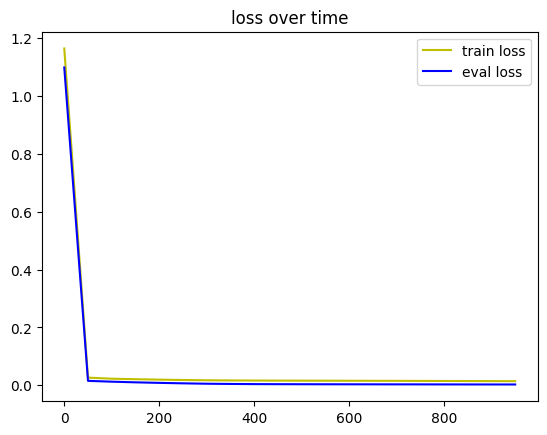

In [ ]:
plt.title('loss over time')
with torch.inference_mode():
    plt.plot(time, train_loss, c = 'y', label = 'train loss')
    plt.plot(time, eval_loss, c = 'b', label = 'eval loss')
plt.legend()
plt.show()

### 4. evaluation

In [ ]:
print(f'testing accuracy: {accuracy_score(model(X_test), y_test)}%')

testing accuracy: 100.0%


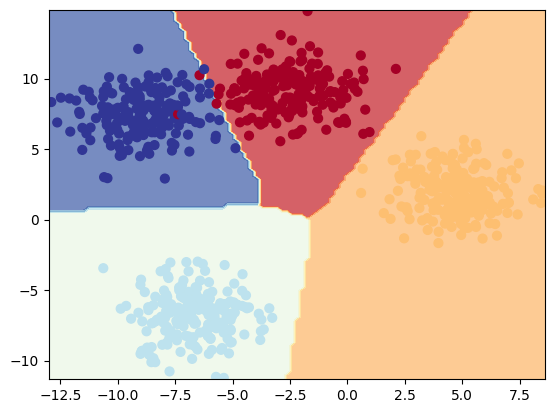

In [ ]:
plot_decision_boundary(model, X_train, y_train)

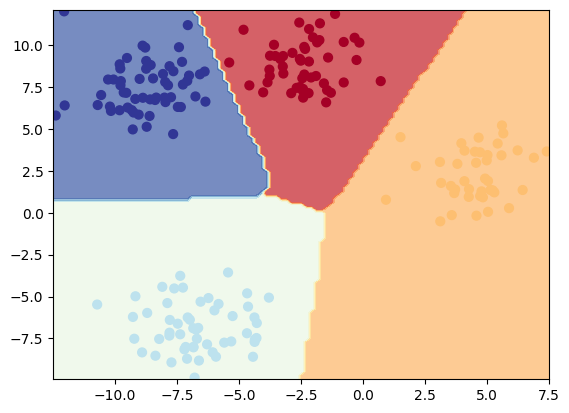

In [ ]:
plot_decision_boundary(model, X_test, y_test)

In [22]:
pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu